# Langton's ant in procedurally-generated infinite adversarial environments


**Mitchell Krawiec-Thayer**
_Email:_ ant@mitchellpkt.com

This notebook will explore the dynamics of Langton's ant within an infinite adversarial environment. Please see the README for details



## Import libraries

In [1]:
from enum import auto, IntEnum
from typing import Tuple, List, Dict, Callable, Any

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from pydantic import BaseModel
from tqdm.auto import tqdm

## Define misc aspects of simulation

In [2]:
class Color(IntEnum):
    WHITE = 1
    BLACK = 0


class Direction(IntEnum):
    UP = auto()
    RIGHT = auto()
    DOWN = auto()
    LEFT = auto()


default_color_mapper: Dict[int, str] = {0: "black", 1: "pink"}


class Ant(BaseModel):
    position: Tuple[int, int] = (0, 0)
    direction: Direction = Direction.UP
    turn_mapping: Dict[Color, Dict[Direction, Direction]] = {
        Color.WHITE: {
            Direction.UP: Direction.RIGHT,
            Direction.RIGHT: Direction.DOWN,
            Direction.DOWN: Direction.LEFT,
            Direction.LEFT: Direction.UP,
        },
        Color.BLACK: {
            Direction.UP: Direction.LEFT,
            Direction.RIGHT: Direction.UP,
            Direction.DOWN: Direction.RIGHT,
            Direction.LEFT: Direction.DOWN,
        },
    }

    def move(self) -> None:
        next_position = None
        if self.direction == Direction.UP:
            next_position = (self.position[0] - 1, self.position[1])
        elif self.direction == Direction.RIGHT:
            next_position = (self.position[0], self.position[1] + 1)
        elif self.direction == Direction.DOWN:
            next_position = (self.position[0] + 1, self.position[1])
        elif self.direction == Direction.LEFT:
            next_position = (self.position[0], self.position[1] - 1)
        else:
            raise ValueError(
                f"?? How did you get here? The forbidden 5th direction: {self.direction}"
            )
        self.position = next_position

    def turn(self, color: Color) -> None:
        self.direction = self.turn_mapping[color][self.direction]


class Board(BaseModel):
    initial_color_picker: Callable[[Tuple[int, int]], Color]
    board: Dict[Tuple[int, int], Color] = dict()
    initial_colors_memory: List[Tuple[int, int, int]] = []

    def flip(self, position: Tuple[int, int]) -> None:
        self.board[position] = (
            Color.BLACK if self.board[position] == Color.WHITE else Color.WHITE
        )

    def get_color(self, position: Tuple[int, int]) -> Color:
        if position not in self.board:
            self.board[position] = self.initial_color_picker(position)
            self.initial_colors_memory.append(
                (position[0], position[1], self.board[position].value)
            )  # noqa
        return self.board[position]


class LangtonsAntSimulation(BaseModel):
    board: Board
    ant: Ant
    iterations: int = 10_000
    history: List[Tuple[int, int, int]] = []
    color_mapper = default_color_mapper

    def __init__(self, **data):
        super().__init__(**data)

    def run(self) -> None:
        for _ in tqdm(range(self.iterations), mininterval=1):  # noqa
            position = self.ant.position
            color = self.board.get_color(position)
            self.ant.turn(color)
            self.board.flip(position)
            self.ant.move()
            self.history.append(
                (
                    position[0],
                    position[1],
                    Color.WHITE.value if color == Color.BLACK else Color.BLACK.value,
                )
            )  # noqa

    def plot_initial_board(self, filename: str = None, **kwargs) -> None:
        plt.figure(figsize=(10, 10))
        c = [self.color_mapper[c] for _, _, c in self.board.initial_colors_memory]
        kwargs.setdefault("s", 10)
        kwargs.setdefault("marker", "s")
        plt.scatter(
            *zip(*[(x, y) for x, y, _ in self.board.initial_colors_memory]),
            c=c,
            **kwargs,
        )
        plt.axis("equal")
        plt.title("initial board (squares explored by ant)")
        if filename is not None:
            plt.savefig(filename)

    def plot_final_board(self, filename: str = None, **kwargs) -> None:
        plt.figure(figsize=(10, 10))
        c = [self.color_mapper[c] for _, _, c in self.history]
        kwargs.setdefault("s", 10)
        kwargs.setdefault("marker", "s")
        plt.scatter(*zip(*[(x, y) for x, y, _ in self.history]), c=c, **kwargs)
        plt.axis("equal")
        plt.title("final board (squares explored by ant)")
        if filename is not None:
            plt.savefig(filename)

    def animate(self) -> FuncAnimation:
        fig, ax = plt.subplots(figsize=(10, 10))
        scatter = ax.scatter(
            *zip(*[(x, y) for x, y, _ in self.history]),
            c=[c for _, _, c in self.history],
            s=1,
        )

        def update(frame_number: int):
            scatter.set_offsets([(x, y) for x, y, _ in self.history[:frame_number]])
            scatter.set_array(np.array([c for _, _, c in self.history[:frame_number]]))

        return FuncAnimation(fig, update, frames=len(self.history), interval=200)

## Demos

### Demo #1: diagonal lines

  0%|          | 0/10000 [00:00<?, ?it/s]

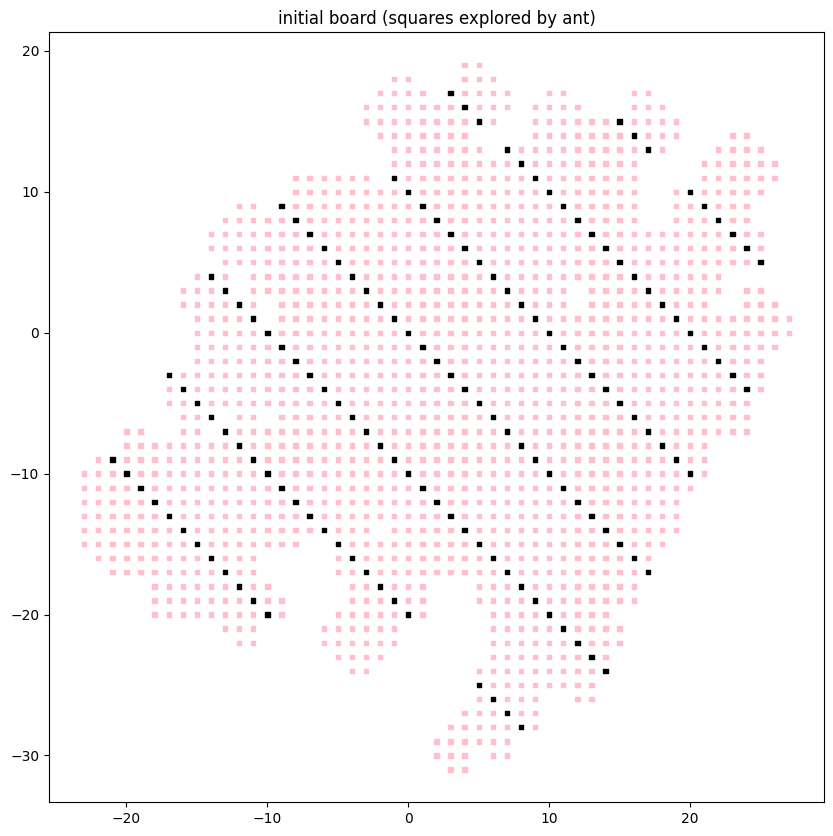

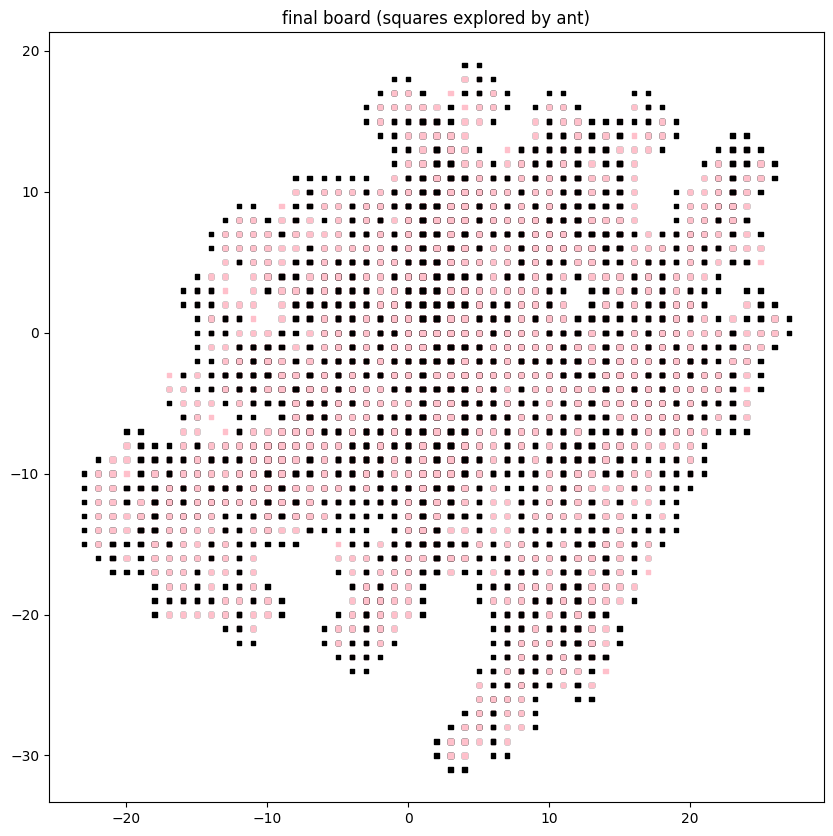

In [3]:
def diagonals(position: Tuple[int, int]) -> Color:
    x, y = position
    return Color.BLACK if (x + y) % 10 == 0 else Color.WHITE


ant: Ant = Ant(position=(0, 0), direction=Direction.UP)
board: Board = Board(initial_color_picker=diagonals)
l: LangtonsAntSimulation = LangtonsAntSimulation(board=board, ant=ant, iterations=10000)
l.run()
l.plot_initial_board()
l.plot_final_board()

### Demo #2: concentric circles

  0%|          | 0/10000 [00:00<?, ?it/s]

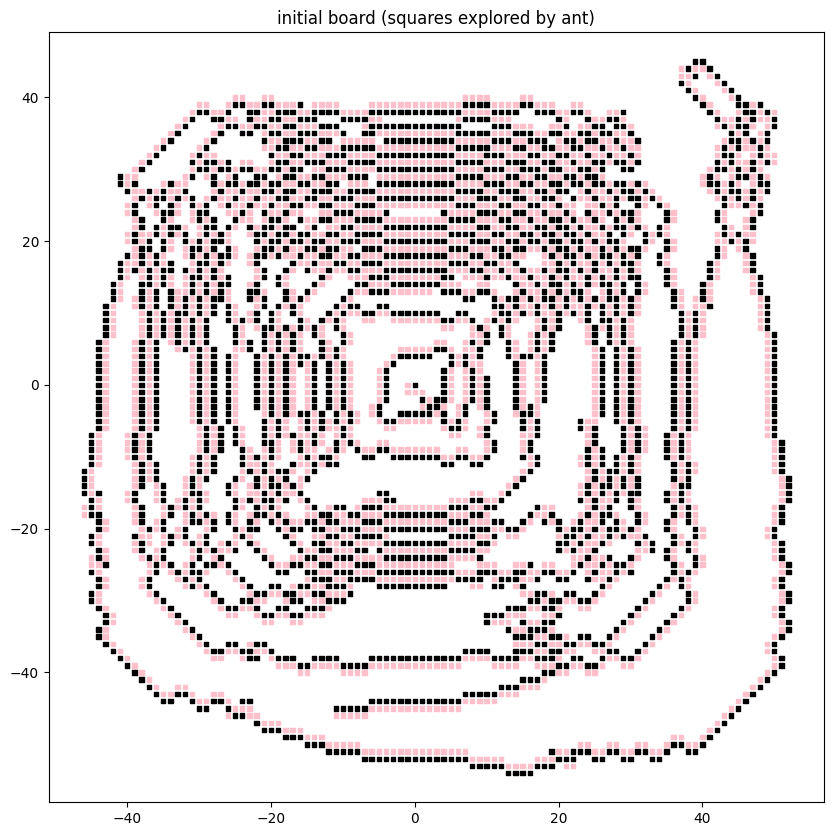

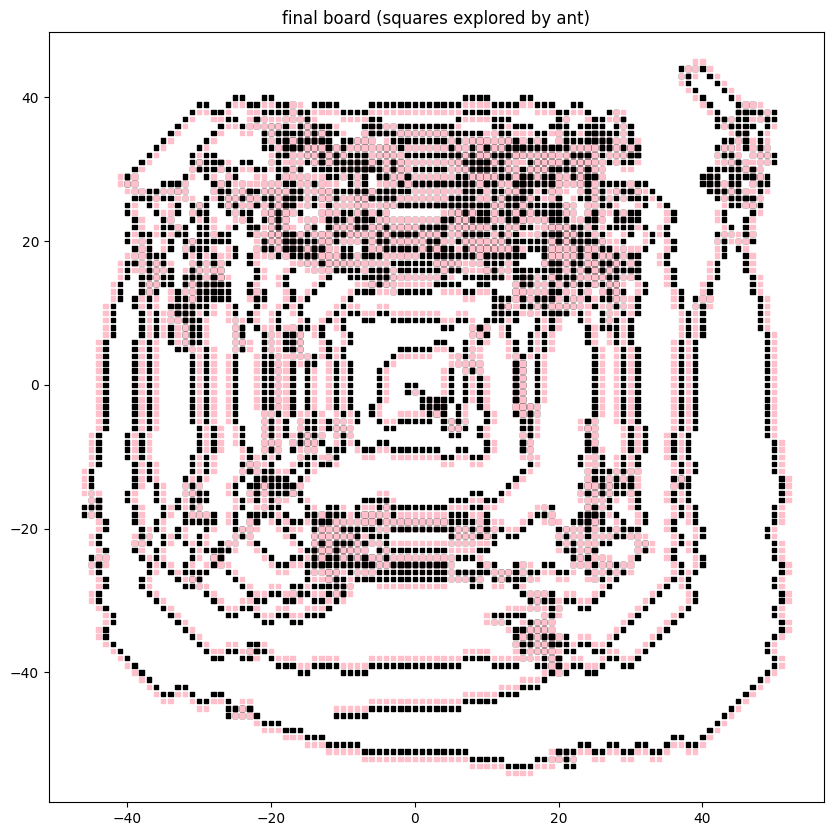

In [4]:
def concentric_circles(position: Tuple[int, int]) -> Color:
    x, y = position
    distance_from_center = round((x**2 + y**2) ** 0.5)
    return Color.BLACK if distance_from_center % 2 == 0 else Color.WHITE


ant: Ant = Ant(position=(0, 0), direction=Direction.UP)
board: Board = Board(initial_color_picker=concentric_circles)
l: LangtonsAntSimulation = LangtonsAntSimulation(board=board, ant=ant, iterations=10000)
l.run()
l.plot_initial_board()
l.plot_final_board()

### Demo #3: concentric circles large

  0%|          | 0/1000000 [00:00<?, ?it/s]

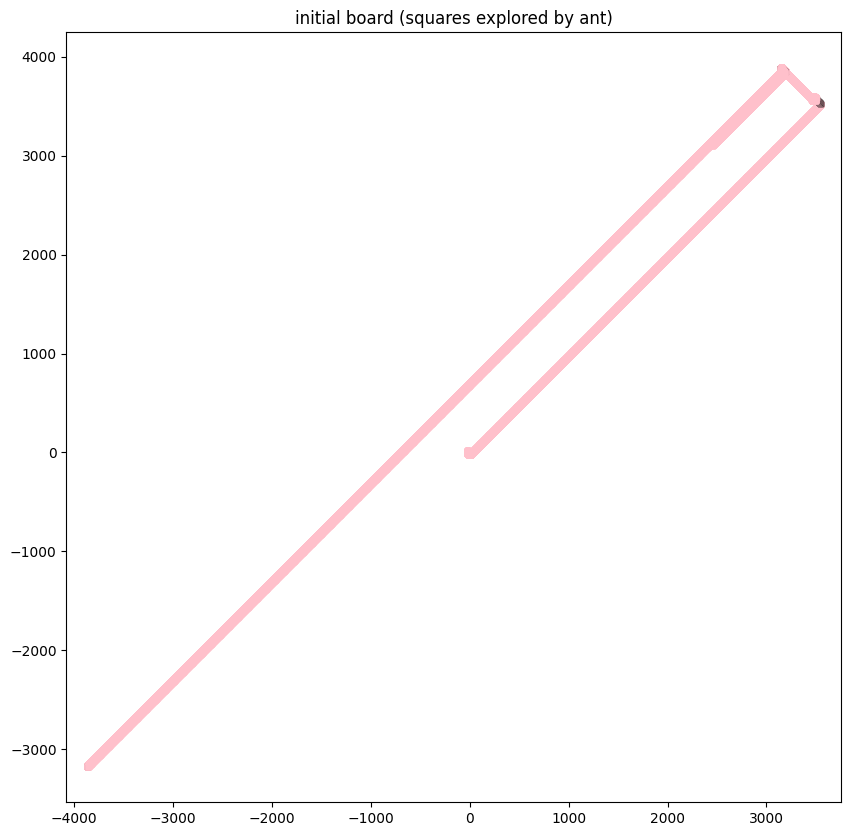

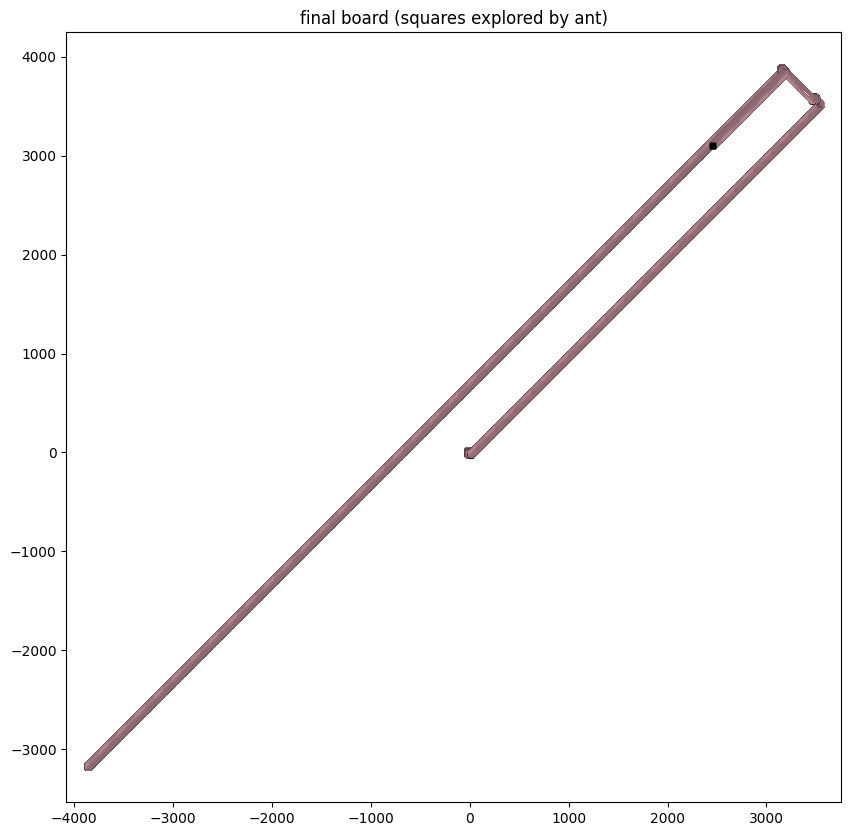

In [5]:
def concentric_circles_large(position: Tuple[int, int]) -> Color:
    x, y = position
    distance_from_center = round((x**2 + y**2) ** 0.5)
    return Color.BLACK if distance_from_center % 5000 == 0 else Color.WHITE


board: Board = Board(initial_color_picker=concentric_circles_large)
ant: Ant = Ant(position=(0, 0), direction=Direction.UP)
l: LangtonsAntSimulation = LangtonsAntSimulation(
    board=board, ant=ant, iterations=1_000_000
)
l.run()
l.plot_initial_board()
l.plot_final_board()

### Demo #4: diagonals large

  0%|          | 0/1000000 [00:00<?, ?it/s]

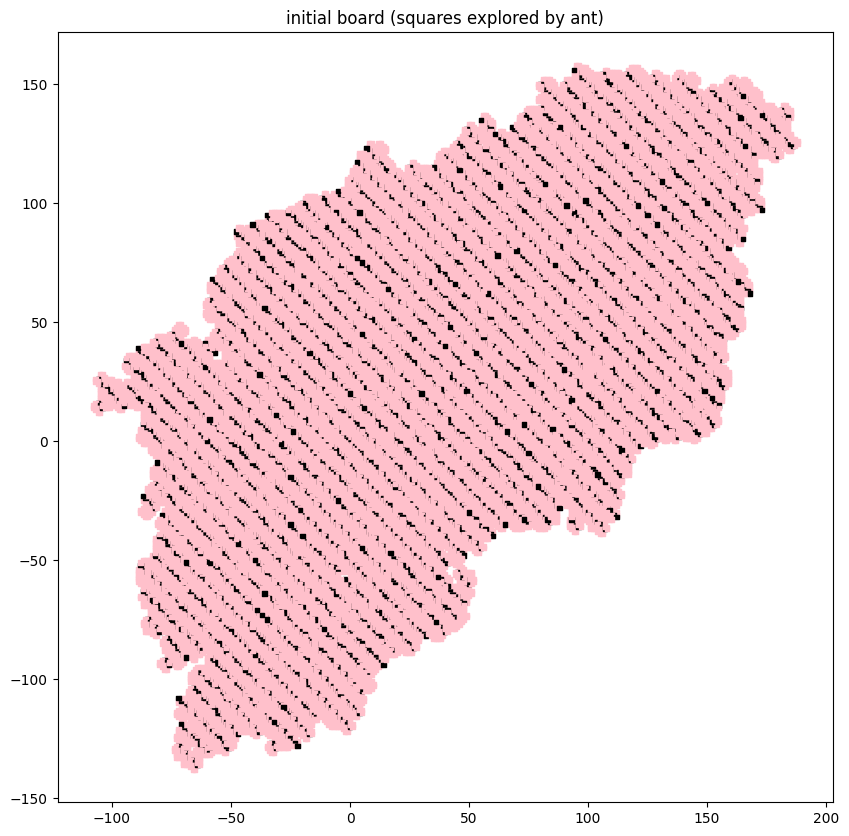

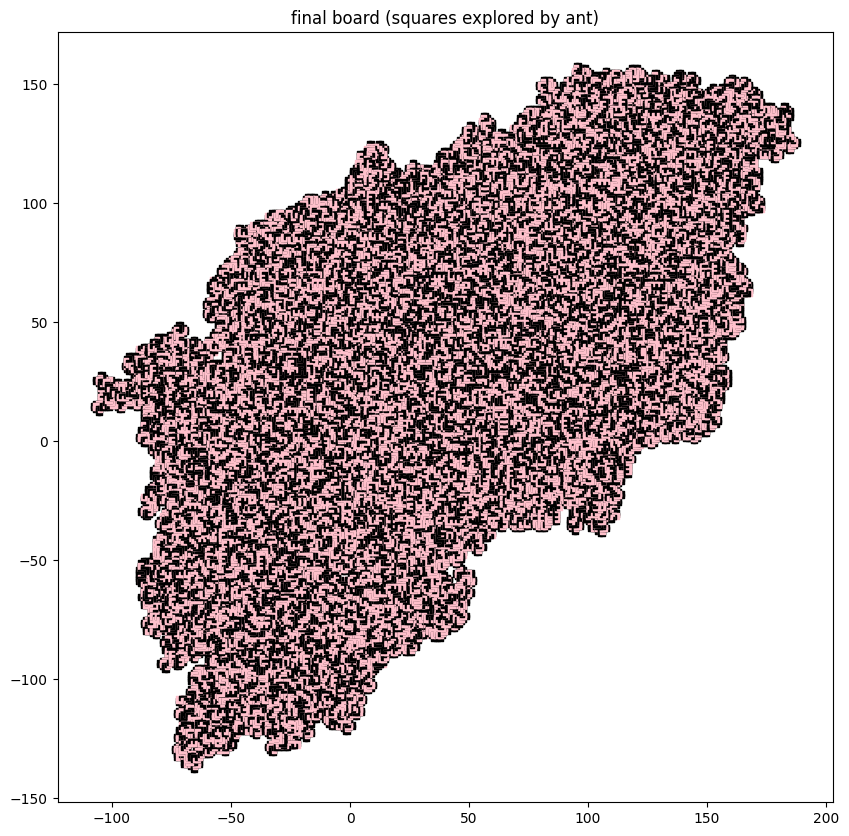

In [6]:
def diagonals_large(position: Tuple[int, int]) -> Color:
    x, y = position
    return Color.BLACK if (x + y) % 100 == 0 else Color.WHITE


ant: Ant = Ant(position=(0, 0), direction=Direction.UP)
board: Board = Board(initial_color_picker=diagonals)
l: LangtonsAntSimulation = LangtonsAntSimulation(
    board=board, ant=ant, iterations=1_000_000
)
l.run()
l.plot_initial_board()
l.plot_final_board()